In [1]:
import gpboost as gpb
import lightgbm as lgb
import numpy as np
import numpy.linalg as la
from collections import OrderedDict
from scipy import stats
from linearmodels.datasets import wage_panel
import matplotlib.pyplot as plt
import pandas as pd
from linearmodels.panel import compare
import statsmodels.api as sm
from linearmodels.panel import RandomEffects
from linearmodels.panel import BetweenOLS
from linearmodels.panel import FirstDifferenceOLS
from linearmodels import PanelOLS
from linearmodels import PooledOLS
from statsmodels.datasets import grunfeld
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
plt.style.use('ggplot')
def f1d(x):
    """Non-linear function for simulation"""
    return (1.7 * (1 / (1 + np.exp(-(x - 0.5) * 20)) + 0.75 * x))
print("It is recommended that the examples are run in interactive mode")

C:\Users\stanislav.ilyushin\Anaconda3\envs\rapid\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


It is recommended that the examples are run in interactive mode


In [2]:
data = wage_panel.load()
year = pd.Categorical(data.year)
data = data.set_index(["nr", "year"])
data["year"] = year
print(wage_panel.DESCR)
print(data.head())


F. Vella and M. Verbeek (1998), "Whose Wages Do Unions Raise? A Dynamic Model
of Unionism and Wage Rate Determination for Young Men," Journal of Applied
Econometrics 13, 163-183.

nr                       person identifier
year                     1980 to 1987
black                    =1 if black
exper                    labor market experience
hisp                     =1 if Hispanic
hours                    annual hours worked
married                  =1 if married
educ                     years of schooling
union                    =1 if in union
lwage                    log(wage)
expersq                  exper^2
occupation               Occupation code

         black  exper  hisp  hours  married  educ  union     lwage  expersq  \
nr year                                                                       
13 1980      0      1     0   2672        0    14      0  1.197540        1   
   1981      0      2     0   2320        0    14      1  1.853060        4   
   1982      0    

In [3]:
data.columns

Index(['black', 'exper', 'hisp', 'hours', 'married', 'educ', 'union', 'lwage',
       'expersq', 'occupation', 'year'],
      dtype='object')

In [4]:
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)
data = data.set_index(['firm','year'])

In [5]:
data

invest     value  capital
firm           year                            
General Motors 1935  317.600  3078.500    2.800
               1936  391.800  4661.700   52.600
               1937  410.600  5387.100  156.900
               1938  257.700  2792.200  209.200
               1939  330.800  4313.200  203.400
...                      ...       ...      ...
American Steel 1950    4.770    36.494   75.847
               1951    6.532    46.082   77.367
               1952    7.329    57.616   78.631
               1953    9.020    57.441   80.215
               1954    6.281    47.165   83.788

[220 rows x 3 columns]

In [6]:
mod_pooled = PooledOLS(data.invest, data[['value', 'capital']])
res_pooled = mod_pooled.fit(cov_type= 'robust')
fittedvals_pooled_OLS = res_pooled.predict().fitted_values
residuals_pooled_OLS = res_pooled.resids

In [7]:
print(res_pooled)

                          PooledOLS Estimation Summary                          
Dep. Variable:                 invest   R-squared:                        0.8577
Estimator:                  PooledOLS   R-squared (Between):              0.8914
No. Observations:                 220   R-squared (Within):               0.6868
Date:                Mon, Mar 21 2022   R-squared (Overall):              0.8577
Time:                        19:58:52   Log-likelihood                   -1311.4
Cov. Estimator:                Robust                                           
                                        F-statistic:                      656.92
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,218)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             194.95
                            

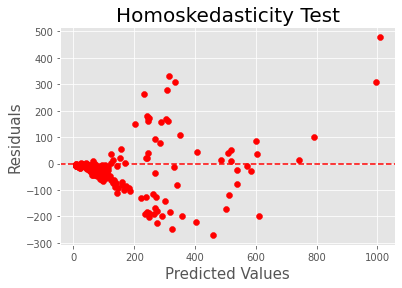

In [8]:
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'red')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel(xlabel = "Predicted Values", fontsize = 15)
ax.set_ylabel("Residuals", fontsize = 15)
ax.set_title("Homoskedasticity Test", fontsize = 20)
plt.show()

In [9]:
# Тест Вайта
pooled_OLS_dataset = pd.concat([data, residuals_pooled_OLS], axis=1)
exog = sm.tools.tools.add_constant(data[['value', 'capital']]).fillna(0)
white_test_results = het_white(pooled_OLS_dataset["residual"], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F pval'] 
print(dict(zip(labels, white_test_results)))
# Тест Бройша
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F pval']  
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 133.01613651702922, 'LM p-val': 5.449364234227589e-27, 'F-Stat': 65.44996295828379, 'F pval': 3.054055442758083e-41}
{'LM-Stat': 82.20291853902968, 'LM p-val': 1.4120921576206973e-18, 'F-Stat': 64.72572979719419, 'F pval': 9.00909625866178e-23}


In [10]:
# гетероскедастичность по двум тестам

In [11]:
exog = data[['value', 'capital']]
endog = data['invest']
# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit(cov_type="robust") 
# fixed effects model
exog = data[['value', 'capital']]
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit(cov_type="robust") 
#print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                 invest   R-squared:                        0.7734
Estimator:              RandomEffects   R-squared (Between):              0.8409
No. Observations:                 220   R-squared (Within):               0.7658
Date:                Mon, Mar 21 2022   R-squared (Overall):              0.8285
Time:                        19:58:59   Log-likelihood                   -1176.0
Cov. Estimator:                Robust                                           
                                        F-statistic:                      372.12
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,218)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             36.659
                            

In [20]:
fittedvals_re_OLS = re_res.predict().fitted_values
residuals_re_OLS = re_res.resids

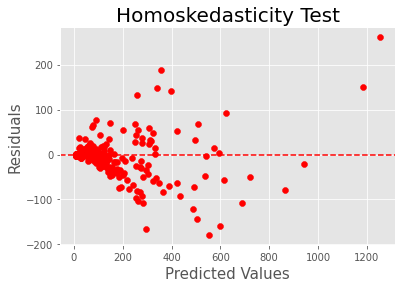

In [21]:
fig, ax = plt.subplots()
ax.scatter(fittedvals_re_OLS, residuals_re_OLS, color = 'red')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel(xlabel = "Predicted Values", fontsize = 15)
ax.set_ylabel("Residuals", fontsize = 15)
ax.set_title("Homoskedasticity Test", fontsize = 20)
plt.show()

In [22]:
# Тест Вайта
pooled_OLS_dataset = pd.concat([data, residuals_re_OLS], axis=1)
exog = sm.tools.tools.add_constant(data[['value', 'capital']]).fillna(0)
white_test_results = het_white(pooled_OLS_dataset["residual"], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F pval'] 
print(dict(zip(labels, white_test_results)))
# Тест Бройша
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F pval']  
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 122.26560839830552, 'LM p-val': 1.039316134893161e-24, 'F-Stat': 53.54274942206474, 'F pval': 7.014296768481213e-36}
{'LM-Stat': 88.68232371046676, 'LM p-val': 5.531947948799527e-20, 'F-Stat': 73.2729392909047, 'F pval': 4.844011352564909e-25}


In [155]:
# fe slightly better

In [23]:
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e6].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval
hausman_results = hausman(fe_res, re_res) 
print("chi-Squared:" + str(hausman_results[0]))
print("degrees of freedom:" + str(hausman_results[1]))
print("p-Value:" + str(hausman_results[2]))

chi-Squared:-1.199170511653052
degrees of freedom:2
p-Value:1.0


In [95]:
# 0 hyp not rejected

In [24]:
mod = FirstDifferenceOLS(data['invest'], data[['value', 'capital']])
fd_res = mod.fit()
print(fd_res)

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                 invest   R-squared:                        0.4287
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.8643
No. Observations:                 209   R-squared (Within):               0.7539
Date:                Mon, Feb 21 2022   R-squared (Overall):              0.8461
Time:                        15:14:11   Log-likelihood                   -1071.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      77.679
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(2,207)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             77.679
                            

In [25]:
mod = BetweenOLS(data.invest, data[['value', 'capital']])
be_res = mod.fit()
print(be_res)

                         BetweenOLS Estimation Summary                          
Dep. Variable:                 invest   R-squared:                        0.9106
Estimator:                 BetweenOLS   R-squared (Between):              0.9106
No. Observations:                  11   R-squared (Within):               0.3648
Date:                Mon, Feb 21 2022   R-squared (Overall):              0.8207
Time:                        15:14:23   Log-likelihood                   -62.020
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      45.854
Entities:                          11   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                     F(2,9)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             45.854
                            

In [26]:
print(compare({"BE": be_res, "RE": re_res, "Pooled": res_pooled, 'FE': fe_res, 'FD': fd_res}))

                                             Model Comparison                                             
                                    BE                RE        Pooled           FE                     FD
----------------------------------------------------------------------------------------------------------
Dep. Variable                   invest            invest        invest       invest                 invest
Estimator                   BetweenOLS     RandomEffects     PooledOLS     PanelOLS     FirstDifferenceOLS
No. Observations                    11               220           220          220                    209
Cov. Est.                   Unadjusted            Robust        Robust       Robust             Unadjusted
R-squared                       0.9106            0.7734        0.8577       0.7667                 0.4287
R-Squared (Within)              0.3648            0.7658        0.6868       0.7667                 0.7539
R-Squared (Between)             0.910

In [27]:
# посмотрим на лучшую модель в плане оценивания матрицы ковариации ЕЁ RE

In [28]:
exog_vars = ['value', 'capital']
exog = sm.add_constant(data[exog_vars])
mod = RandomEffects(data.invest, exog)
robust = mod.fit(cov_type="robust")

In [29]:
clust_entity = mod.fit(cov_type="clustered", cluster_entity=True)

In [30]:
clust_entity_time = mod.fit(cov_type="clustered", cluster_entity=True, cluster_time=True)

In [31]:
res = OrderedDict()
res["Robust"] = robust
res["Entity"] = clust_entity
res["Entity-Time"] = clust_entity_time
print(compare(res))

                           Model Comparison                          
                               Robust          Entity     Entity-Time
---------------------------------------------------------------------
Dep. Variable                  invest          invest          invest
Estimator               RandomEffects   RandomEffects   RandomEffects
No. Observations                  220             220             220
Cov. Est.                      Robust       Clustered       Clustered
R-squared                      0.7700          0.7700          0.7700
R-Squared (Within)             0.7666          0.7666          0.7666
R-Squared (Between)            0.8204          0.8204          0.8204
R-Squared (Overall)            0.8080          0.8080          0.8080
F-statistic                    363.21          363.21          363.21
P-value (F-stat)               0.0000          0.0000          0.0000
===================== =============== =============== ===============
const               